<a href="https://colab.research.google.com/github/davidsu-zhixiang/CSS-Project-5/blob/main/Copy_of_Project_5_Student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# update the gensim
!pip install --upgrade gensim

## update Google Colab's sklearn package to the latest version
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install --upgrade gensim

# if an erro occurs, it's beacuse the TfidfV package not updated 
!pip uninstall scikit-learn

!pip install -U scikit-learn==1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: scikit-learn 1.0
Uninstalling scikit-learn-1.0:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/scikit_learn-1.0.dist-info/*
    /usr/local/lib/python3.9/dist-packages/scikit_learn.libs/libgomp-f7e03b3e.so.1.0.0
    /usr/local/lib/python3.9/dist-packages/sklearn/*
Proceed (Y/n)? y
  Successfully uninstalled scikit-learn-1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-1.0-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (24.7 MB)


In [3]:
# pandas and numpy
import pandas as pd
import numpy as numpy
import re
import tqdm

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
congress_tweets = pd.read_csv("https://raw.githubusercontent.com/davidsu-zhixiang/Computational-Social-Science-Projects/main/congress_tweets_sample50k.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
## first try on a sample of  1000 tweets
congress_tweets = congress_tweets.sample(n=10000, random_state=1)
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,noemoji
26247,1.240780e+18,RepAndyBiggsAZ,2020-03-19T19:29:06-04:00,RT @GilbertFireDept THREAD: We serve the best ...,Andy Biggs,Rep,3-Jan-17,11/7/1958,M,AZ,5,Republican,"1,252,401","1,161,167","1,025,232","1,233,654",RT @GilbertFireDept THREAD: We serve the best ...
35067,1.255230e+18,RepMcKinley,2020-04-28T15:59:20-04:00,RT @FinancialCmte The #PaycheckProtectionProgr...,David McKinley,Rep,3-Jan-11,3/28/1947,M,WV,1,Republican,"489,371","188,794","238,269","417,655",RT @FinancialCmte The #PaycheckProtectionProgr...
34590,1.254050e+18,SenWhitehouse,2020-04-25T10:11:23-04:00,"First, we need to conquer an enemy within: a c...",Sheldon Whitehouse,Sen,3-Jan-07,10/20/1955,M,RI,Senate,Democrat,"180,543","252,525","279,677","157,204","First, we need to conquer an enemy within: a c..."
16668,1.205930e+18,RepMarkGreen,2019-12-14T14:26:15-05:00,#GoArmy #BeatNavy! http://pbs.twimg.com/ext_tw...,Mark E. Green,Rep,3-Jan-19,11/8/1964,M,TN,7,Republican,"1,522,925","870,695","960,709","1,462,330",#GoArmy #BeatNavy! http://pbs.twimg.com/ext_tw...
12196,1.261000e+18,RepKendraHorn,2020-05-14T14:27:57-04:00,I know we can find common ground to address th...,Kendra Horn,Rep,3-Jan-19,6/9/1976,F,OK,5,Democrat,"949,136","420,375","443,547","891,325",I know we can find common ground to address th...


In [5]:
congress_tweets.shape

(10000, 17)

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [6]:

# remove all the emoji in the text 
def remove_emoji(text):
    # Emoji pattern
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                           "]+", flags=re.UNICODE)
    # Remove emoji
    text = emoji_pattern.sub(r'', text)
    return text

# now the text without emoji is stored at congress_tweets['noemoji']
congress_tweets['noemoji'] = congress_tweets['text'].map(lambda x: remove_emoji(x))


In [7]:
# David's function rewriting the rem_punc_stop
## doc = nlp(congress_tweets.loc[:,"text"][2])

def rem_punc_stop(text):

    #print(text)

# david's func to remove RT flags using regular exp
    pattern = re.compile(r'RT\s@\w+\s')
    flag_free = re.sub(pattern, '@', text)

    pattern2 = re.compile(r'\\n+')
    flag_free = re.sub(pattern2, '@', text)

# normal rem_punc_stop
    stop_words = STOP_WORDS

# delete /n, QT, etc
    nlp.Defaults.stop_words.add("\n\n")
    nlp.Defaults.stop_words.add("\n")
    nlp.Defaults.stop_words.add("amp")
    nlp.Defaults.stop_words.add("QT")
    nlp.Defaults.stop_words.add("RT")
    nlp.Defaults.stop_words.add("RT ") 

    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in flag_free if ch not in punc])
    
    doc = nlp(punc_free)

    # lemmatization
    lemmatized_text = " ".join([token.lemma_ for token in doc])

    lemma_doc = nlp(lemmatized_text)
    
    spacy_words = [token.text for token in lemma_doc]

 # delete anything starting with http (URL)   
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
 
    no_punc = [word for word in spacy_words if word not in stop_words]

    return no_punc

In [8]:
congress_tweets['tokens'] = congress_tweets['noemoji'].map(lambda x: rem_punc_stop(x)) #~23 seconds for 1000 obs sample
#congress_tweets['noemoji'][0]

In [9]:
# David's function to extract the source owner of this tweet (forward flag)
def forward_from(text):
  # extract the forward flag
    pattern = re.compile(r'RT\s@\w+\s')
    matches = re.findall(pattern, text)

  # normal rem_punc_stop
    stop_words = STOP_WORDS
    nlp.Defaults.stop_words.add("RT")
    nlp.Defaults.stop_words.add("RT ") 

    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in matches if ch not in punc])
    
    doc = nlp(punc_free)

    spacy_words = [token.text for token in doc]

    no_punc = [word for word in spacy_words if word not in stop_words]

    return no_punc


In [10]:
# the forwarding information is stored at congress_tweets['forward'] 
congress_tweets['forward'] = congress_tweets['noemoji'].map(lambda x: forward_from(x))
congress_tweets['forward']

26247    [@GilbertFireDept]
35067      [@FinancialCmte]
34590                    []
16668                    []
12196                    []
                ...        
49858                    []
19849                    []
46899                    []
28256       [@ArlingtonHHS]
43070                    []
Name: forward, Length: 10000, dtype: object

In [11]:
# let's see how the text preprocessing turns out

congress_tweets['noemoji'].iloc[0]
congress_tweets['tokens']

# look like its successful
# now we have a new column "token" in the dataset congress_tweets['tokens']

26247    [GilbertFireDept, THREAD, serve, good, communi...
35067    [FinancialCmte, PaycheckProtectionProgram, hel...
34590    [need, conquer, enemy, corrupt, antiscience, a...
16668                                   [GoArmy, BeatNavy]
12196    [I, know, find, common, ground, address, healt...
                               ...                        
49858    [IL, student, Applications, congressional, nom...
19849    [REMINDER, forget, file, taxis, Wednesday, Jul...
46899    [senior, night,   , UNI, wrestling, dual, 4, s...
28256    [ArlingtonHHS, vaccination, effort, underway, ...
43070    [wait, fill, 2020census, easy, secure, importa...
Name: tokens, Length: 10000, dtype: object

In [12]:
congress_tweets['tokens']

26247    [GilbertFireDept, THREAD, serve, good, communi...
35067    [FinancialCmte, PaycheckProtectionProgram, hel...
34590    [need, conquer, enemy, corrupt, antiscience, a...
16668                                   [GoArmy, BeatNavy]
12196    [I, know, find, common, ground, address, healt...
                               ...                        
49858    [IL, student, Applications, congressional, nom...
19849    [REMINDER, forget, file, taxis, Wednesday, Jul...
46899    [senior, night,   , UNI, wrestling, dual, 4, s...
28256    [ArlingtonHHS, vaccination, effort, underway, ...
43070    [wait, fill, 2020census, easy, secure, importa...
Name: tokens, Length: 10000, dtype: object

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1

This part usually takes at least 20 minutes to train.

In [13]:
!pip install scattertext
import scattertext as st
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 47.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9307 sha256=200fd8a4ff5707e52b571da4740e80237e945f7f3bbd4356256f7eb367be840c
  Stored in directory: /root/.cache/pip/wheels/65/3c/c7/44672c5062c16d05760b1eaddbf611d2f6a4b715c6d6777418
Successfully built flashtext


In [14]:
corpus = st.CorpusFromPandas(congress_tweets.astype(str),
                            category_col = 'party',
                            text_col = 'tokens',
                            nlp = nlp).build()
html = st.produce_scattertext_explorer(corpus,
                                       category='Republican',
                                       category_name='Republican',
                                       not_category_name='Democrat',
                                        width_in_pixels=1000,
                                        minimum_term_frequency=5,
                                       metadata=congress_tweets['tweet_id'])
open("Congress Tweets Sentiment.html", 'wb').write(html.encode('utf-8'))

4556304

### EDA 2

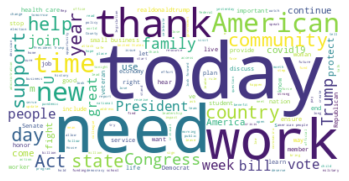

In [15]:
#David - word clouds

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob

text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text)))
wordcloud = WordCloud(background_color = "white").generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

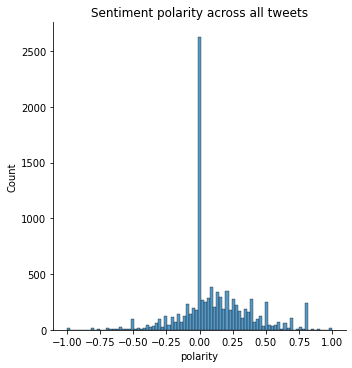

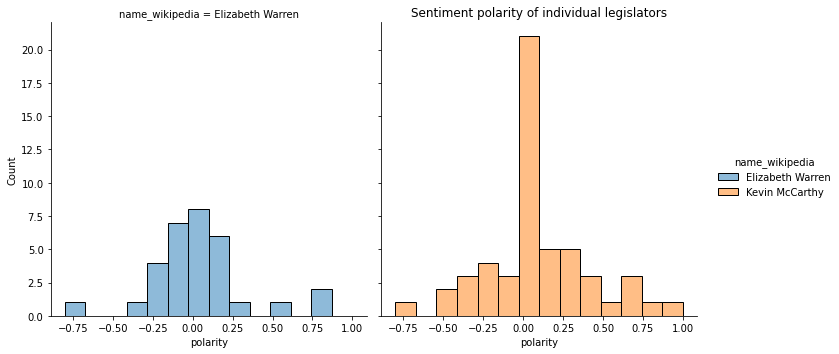

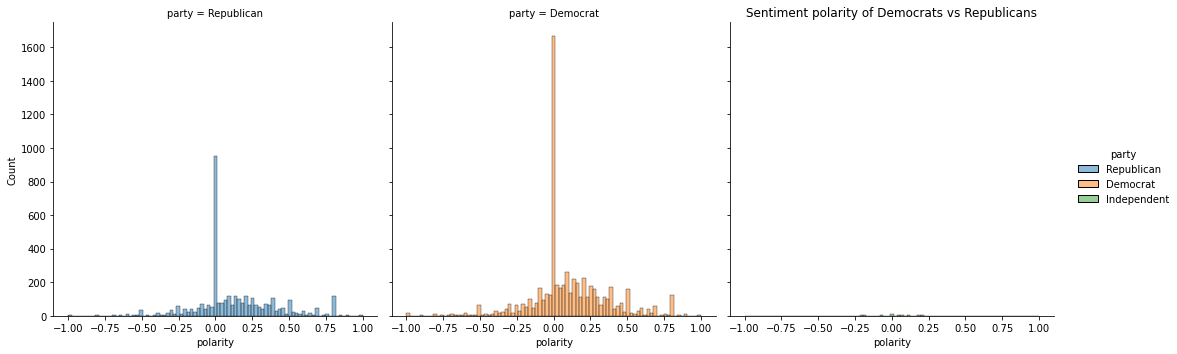

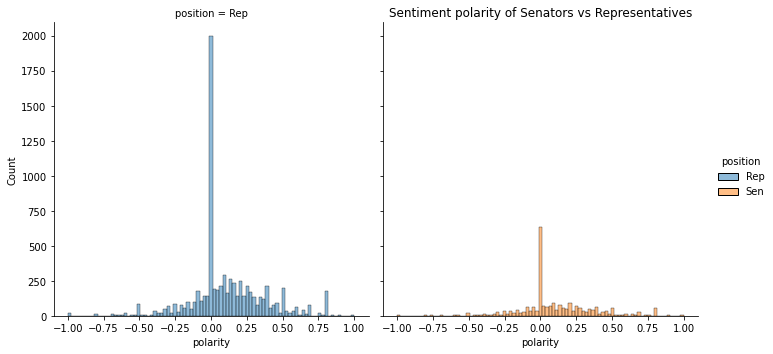

In [16]:
#Caitlin - sentiment polarity

#sentiment across all tweets
tokens = congress_tweets['tokens'].map(lambda text: ' '.join(text))
congress_tweets['polarity'] = tokens.map(lambda text: TextBlob(text).sentiment.polarity)
congress_tweets.head()
sns.displot(congress_tweets, x="polarity")
plt.title("Sentiment polarity across all tweets")
plt.show()

#compare individual legislators
congress_tweets_subset = congress_tweets[congress_tweets['name_wikipedia'].isin(["Elizabeth Warren","Kevin McCarthy"])]
sns.displot(congress_tweets_subset, x="polarity", hue = "name_wikipedia", col = "name_wikipedia")
plt.title("Sentiment polarity of individual legislators")
plt.show()

#compare democrats to republicans
sns.displot(congress_tweets, x="polarity", hue = "party", col = "party")
plt.title("Sentiment polarity of Democrats vs Republicans")
plt.show()

#compare senators to representatives
sns.displot(congress_tweets, x="polarity", hue = "position", col = "position")
plt.title("Sentiment polarity of Senators vs Representatives")
plt.show()


## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [17]:
# Engineered Features - Caitlin
#use sentiment scores as features

# Engineered Text Features
engineered_features = congress_tweets[['polarity']]

engineered_features.head

<bound method NDFrame.head of        polarity
26247  0.175000
35067 -0.347222
34590 -0.100000
16668  0.000000
12196  0.111111
...         ...
49858  0.075000
19849  0.000000
46899  0.000000
28256  0.000000
43070  0.308333

[10000 rows x 1 columns]>

### Bag-of-words or Tf-idf

In [18]:
# Frequency Based featurization - David
X = congress_tweets['tokens']
X = [' '.join(x) for x in X] # join tokens into a single string
tf = TfidfVectorizer(tokenizer = rem_punc_stop)
tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()

In [19]:
feature_names = tf.get_feature_names()

/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [20]:
# feature_names[0:10000]
# X

David: Because I want to store the Tf-idf and the non-text features in to a single dataframe "non_text_plus_tfidf", I better start to sort out the orginal df's nontext variables.

In [21]:
from datetime import date, datetime
congress_tweets["join_year"] = congress_tweets["joined_congress_date"].apply(lambda x: datetime.strptime(x, "%d-%b-%y").date().year)

congress_tweets["person_age"] = date.today().year - congress_tweets["birthday"].apply(lambda x: datetime.strptime(x, "%m/%d/%Y").date().year)

congress_tweets["trump_2016_state_share"] = pd.to_numeric(congress_tweets["trump_2016_state_share"].str.replace(",", ""))
congress_tweets["clinton_2016_state_share"] = pd.to_numeric(congress_tweets["clinton_2016_state_share"].str.replace(",", ""))
congress_tweets["trumpvoteshare"] = congress_tweets["trump_2016_state_share"] / (congress_tweets["trump_2016_state_share"] + congress_tweets["clinton_2016_state_share"])

congress_tweets["obama_2012_state_share"] = pd.to_numeric(congress_tweets["obama_2012_state_share"].str.replace(",", ""))
congress_tweets["romney_2012_state_share"] = pd.to_numeric(congress_tweets["romney_2012_state_share"].str.replace(",", ""))
congress_tweets["obamavoteshare"] = congress_tweets["obama_2012_state_share"] / (congress_tweets["obama_2012_state_share"] + congress_tweets["romney_2012_state_share"])


In [22]:
congress_tweets.columns
# Engineered Text Features
#engineered_features = cfpb[['complaint_len', 'word_count', 'polarity', 'subjectivity']].reset_index(drop = True)

# Non-text features + engineered features
#non_text_engineered_features = non_text_features_dummies.reset_index(drop = True).join(engineered_features_with_topics)

# Topic Model + Engineered Features
#engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True))

# Non-text features
non_text_features_numeric = congress_tweets[['join_year', 'person_age', "trumpvoteshare", "obamavoteshare" ]]

non_text_dummies = congress_tweets[['gender', 'state','district_number']]
non_text_features_dummies = pd.get_dummies(non_text_dummies).reset_index(drop = True)

non_text_features = non_text_features_numeric.reset_index(drop = True).join(non_text_features_dummies)

# Non-text features + tfidf
tfidf_df = pd.DataFrame(dense_matrix, columns = feature_names)
non_text_plus_tfidf = non_text_features.reset_index(drop = True).join(tfidf_df)
non_text_plus_tfidf.shape

(10000, 23233)

### Word Embedding

In [23]:
# embedding based featurization - David
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

#model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 
import pandas as pd
import numpy as np
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

from tqdm import tqdm

import gensim
from gensim import models
from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.manifold import TSNE

import multiprocessing

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
# training work embeddings
from gensim.models import Word2Vec
# vector_size = size, epochs  = iter
model = gensim.models.Word2Vec(congress_tweets['tokens'], vector_size =100, window=5, 
                               min_count=5, sg=0, alpha=0.025, epochs = 5, batch_words=5000)


In [25]:
# examine work embedding output
words = list(model.wv.index_to_key)
print(words[0:100])
model.wv.__getitem__(['people']).shape

['I', '\n\n ', '  ', '\n ', '"', '’', 'today', 'work', 'need', 'help', 'people', 'thank', 'House', 'community', 'year', 'Act', 'support', 'family', 'health', 'time', 'Trump', 'President', 'm', 'bill', 'Americans', 'Congress', '—', 'join', 'vote', 'US', 'pass', 'continue', 'country', 'american', 'day', 'protect', 'fight', 'right', 'great', 'new', 'care', 'Senate', 'business', 'state', 'week', 'life', 'million', 'covid19', 'like', 'woman', 'worker', 'ensure', 'job', 'good', 'come', 'provide', 'federal', 'America', 'student', 'proud', 'law', 'realdonaldtrump', 'service', 'live', 'Democrats', 'way', 'know', 'honor', 'important', 'crisis', '\n \n ', 'legislation', 'nation', 'public', 'look', 'use', 'include', '–', 'small', 'bipartisan', 've', 'stop', 'hear', 'pandemic', 'member', 'child', 'want', 'economy', 'hold', 'safe', 'government', 'school', 'stand', 'COVID19', 'change', '\n  ', 'coronavirus', 'access', 'end', 'action']


(1, 100)

In [26]:
# averaging workd embedding by documents (if nothing detected in the doc, return
# a vector of zeros)
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.index_to_key]
    if len(doc) > 0:
        return np.mean(model.wv.__getitem__(doc), axis=0)
    else:
        return np.zeros((model.vector_size,))
  

In [27]:
print([congress_tweets['tokens']])

[26247    [GilbertFireDept, THREAD, serve, good, communi...
35067    [FinancialCmte, PaycheckProtectionProgram, hel...
34590    [need, conquer, enemy, corrupt, antiscience, a...
16668                                   [GoArmy, BeatNavy]
12196    [I, know, find, common, ground, address, healt...
                               ...                        
49858    [IL, student, Applications, congressional, nom...
19849    [REMINDER, forget, file, taxis, Wednesday, Jul...
46899    [senior, night,   , UNI, wrestling, dual, 4, s...
28256    [ArlingtonHHS, vaccination, effort, underway, ...
43070    [wait, fill, 2020census, easy, secure, importa...
Name: tokens, Length: 10000, dtype: object]


In [28]:
# Initialize an array for the size of the corpus
temp_list_embeddings_means = []
for puppy in congress_tweets['tokens'].tolist(): # append the vector for each document
    temp_list_embeddings_means.append(document_vector(model, puppy))
    
doc_average_embeddings = np.array(temp_list_embeddings_means) # list to array
doc_average_embeddings

array([[-0.09215696,  0.11891575, -0.03513051, ..., -0.45967469,
         0.13018654, -0.11947668],
       [-0.0856249 ,  0.14549308, -0.21402848, ..., -0.593853  ,
         0.19422717, -0.26940814],
       [-0.19813894,  0.1735789 , -0.05541854, ..., -0.33356097,
         0.07063922, -0.07213878],
       ...,
       [-0.23874971,  0.26992837,  0.06767217, ..., -0.39210477,
         0.07815541,  0.00924839],
       [-0.17958641,  0.1837137 , -0.00373998, ..., -0.37976393,
         0.11471428, -0.04519871],
       [-0.10796036,  0.14754136,  0.02345803, ..., -0.49629402,
         0.166245  , -0.09944499]])

In [29]:
# check the doc embedding - confirmed that it has a right shape

doc_average_embeddings
doc_average_embeddings.shape

# store the doc embedding result in "doc_average_embeddings_df"
doc_average_embeddings_df = pd.DataFrame(doc_average_embeddings)

# combine it with nontext features
non_text_plus_doc_embedding = non_text_features.reset_index(drop = True).join(doc_average_embeddings_df)

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [30]:
# change the Independent to Democrat because they usually vote together
congress_tweets['party_bin'] = congress_tweets['party'].replace('Independent','Democrat')


Caitlin - engineered features (sentiment score) w/ logistic regression to predict party and position

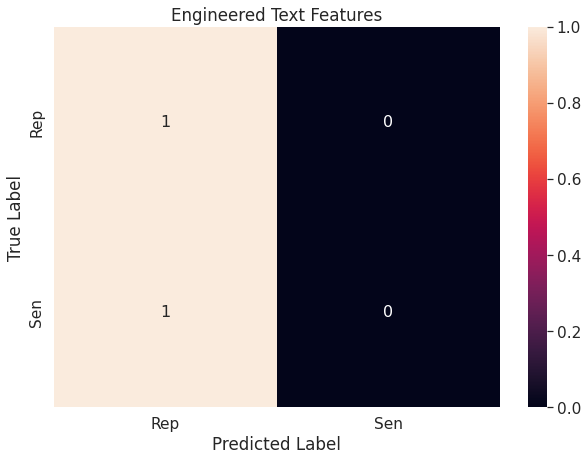

The logit regression's accuracy is: 0.7405
The logit regression's F1 score is: 0.0


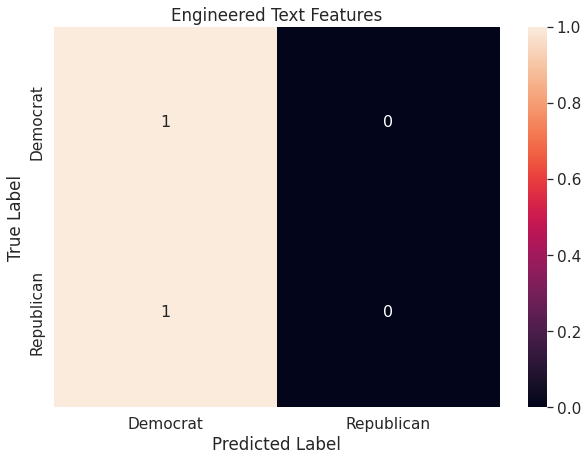

The logit regression's accuracy is: 0.649
The logit regression's F1 score is: 0.0


In [31]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])


dataframes = [engineered_features]

featurization_technique = ['Engineered Text Features']

lb_style = LabelBinarizer()
y = congress_tweets['position_binary'] = lb_style.fit_transform(congress_tweets["position"])

for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Rep", 1: "Sen"})
    df_cm.index = ["Rep", "Sen"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


# calculate accuracy score
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"The logit regression's accuracy is: {accuracy}")

# calculate F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print("The logit regression's F1 score is:", f1)

#logistic regression : E[Sen or Rep] = sentiment scores

dataframes = [engineered_features]

featurization_technique = ['Engineered Text Features']

lb_style = LabelBinarizer()
y = congress_tweets['party_binary'] = lb_style.fit_transform(congress_tweets["party_bin"])

for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
    df_cm.index = ["Democrat", "Republican"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

#Report accuracy

# calculate accuracy score
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"The logit regression's accuracy is: {accuracy}")

# calculate F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print("The logit regression's F1 score is:", f1)

Create two outcome variables for party and senator/house

In [32]:
# David's datacleaning
# Outcomes

Y_position = pd.get_dummies(congress_tweets[['position']]).reset_index(drop = True)

# change the Independent to Democrat because they usually vote together
congress_tweets['party_recoded'] = congress_tweets['party'].map({'Republican': 'Republican', 'Independent': 'Democrat'})
Y_party = pd.get_dummies(congress_tweets[['party_recoded']]).reset_index(drop = True)


David (Caitlin mod) - Model 1
Using tf-idf to predict 
party membership

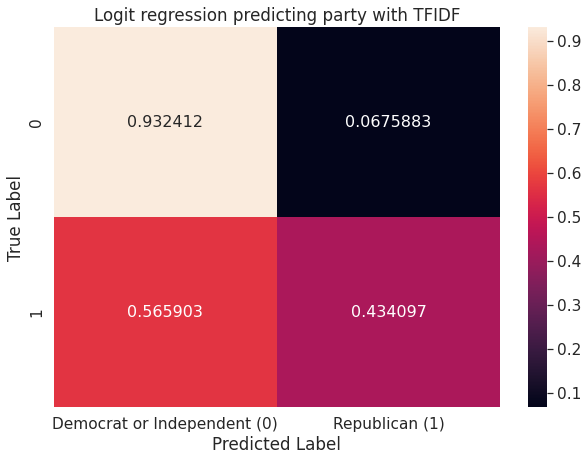

The logit regression's accuracy is: 0.7585
The logit regression's F1 score is: 0.5564738292011019


In [33]:
# split training and test set
X_train, X_test, y_party_train, y_party_test = train_test_split(tfidf_df, Y_party["party_recoded_Republican"],
                                                   train_size = .80,
                                                   test_size = .20,
                                                    random_state = 1)

# create a model using tfidf --> party
logit_reg = LogisticRegression()

logit_model = logit_reg.fit(X_train, y_party_train.ravel())
y_party_pred = logit_model.predict(X_test)
cf_matrix = confusion_matrix(y_party_test, y_party_pred, normalize = "true")
df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))
df_cm = df_cm.rename(index=str, columns={0: "Democrat or Independent (0)", 1: "Republican (1)"})
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
            annot=True,
            annot_kws={"size": 16},
            fmt='g')

plt.title("Logit regression predicting party with TFIDF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# calculate accuracy score
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_party_test, y_party_pred)
print(f"The logit regression's accuracy is: {accuracy}")

# calculate F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_party_test, y_party_pred)
print("The logit regression's F1 score is:", f1)

David (Caitlin mod)- Model 2
Using  tf-idf to predict whether the tweet comes from Senator or Representative

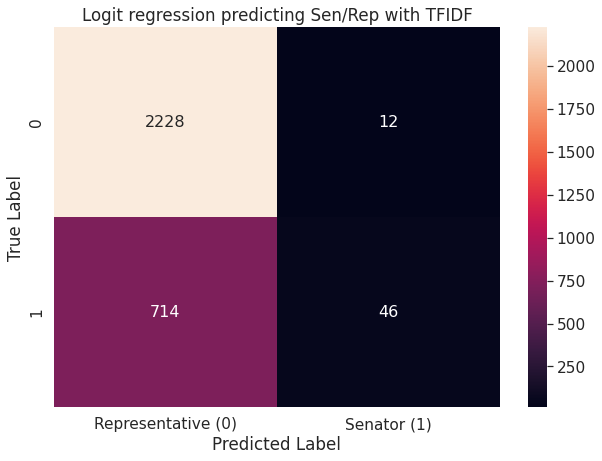

The logit regression's accuracy is: 0.758
The logit regression's F1 score is: 0.11246943765281174


In [34]:
# split training and test set
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, Y_position["position_Sen"],
                                                   train_size = .70,
                                                   test_size = .30,
                                                    random_state = 2)

# create a model using tfidf_nontext --> senator/representative
logit_reg = LogisticRegression()

logit_model = logit_reg.fit(X_train, y_train.ravel())
y_pred = logit_model.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))
df_cm = df_cm.rename(index=str, columns={0: "Representative (0)", 1: "Senator (1)"})
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
            annot=True,
            annot_kws={"size": 16},
            fmt='g')

plt.title("Logit regression predicting Sen/Rep with TFIDF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# calculate accuracy score
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"The logit regression's accuracy is: {accuracy}")

# calculate F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print("The logit regression's F1 score is:", f1)

David (Caitlin mod) - Model 3 Using word embedding to predict party membership

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


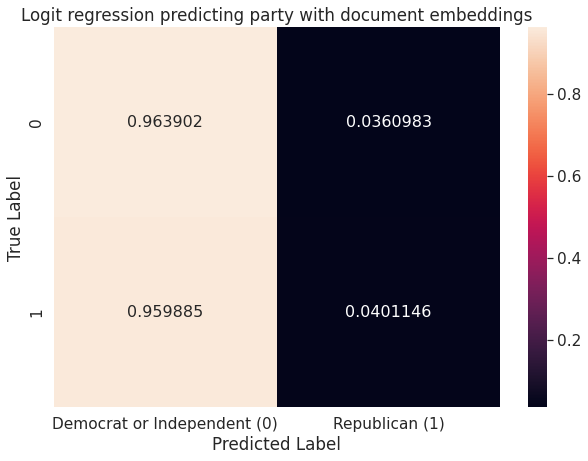

The logit regression's accuracy is: 0.6415
The logit regression's F1 score is: 0.07244501940491592


In [35]:
# split training and test set
X_train, X_test, y_party_train, y_party_test = train_test_split(doc_average_embeddings_df, 
                                                                Y_party["party_recoded_Republican"],
                                                   train_size = .80,
                                                   test_size = .20,
                                                    random_state = 1)

# create a model using tfidf_nontext --> party
logit_reg = LogisticRegression()

logit_model = logit_reg.fit(X_train, y_party_train.ravel())
y_party_pred = logit_model.predict(X_test)
cf_matrix = confusion_matrix(y_party_test, y_party_pred, normalize = "true")
df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))
df_cm = df_cm.rename(index=str, columns={0: "Democrat or Independent (0)", 1: "Republican (1)"})
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
            annot=True,
            annot_kws={"size": 16},
            fmt='g')

plt.title("Logit regression predicting party with document embeddings")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# calculate accuracy score
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_party_test, y_party_pred)
print(f"The logit regression's accuracy is: {accuracy}")

# calculate F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_party_test, y_party_pred)
print("The logit regression's F1 score is:", f1)

David (Caitlin mod) - Model 4 Using word embedding to predict whether the tweet comes from Senator or Representative

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


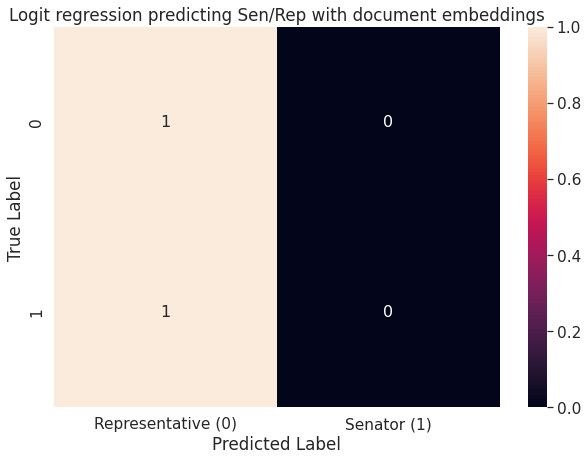

The logit regression's accuracy is: 0.7466666666666667
The logit regression's F1 score is: 0.0


In [36]:
# split training and test set
X_train, X_test, y_train, y_test = train_test_split(doc_average_embeddings_df, Y_position["position_Sen"],
                                                   train_size = .70,
                                                   test_size = .30,
                                                    random_state = 2)

# create a model using tfidf_nontext --> senator/representative
logit_reg = LogisticRegression()

logit_model = logit_reg.fit(X_train, y_train.ravel())
y_pred = logit_model.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred, normalize = 'true')
df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))
df_cm = df_cm.rename(index=str, columns={0: "Representative (0)", 1: "Senator (1)"})
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
            annot=True,
            annot_kws={"size": 16},
            fmt='g')

plt.title("Logit regression predicting Sen/Rep with document embeddings")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# calculate accuracy score
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"The logit regression's accuracy is: {accuracy}")

# calculate F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print("The logit regression's F1 score is:", f1)

### Two Combined Models


# David - Model 1
# Using nontext feature & tf-idf to predict party membership

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:806: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  opt_res = optimize.minimize(


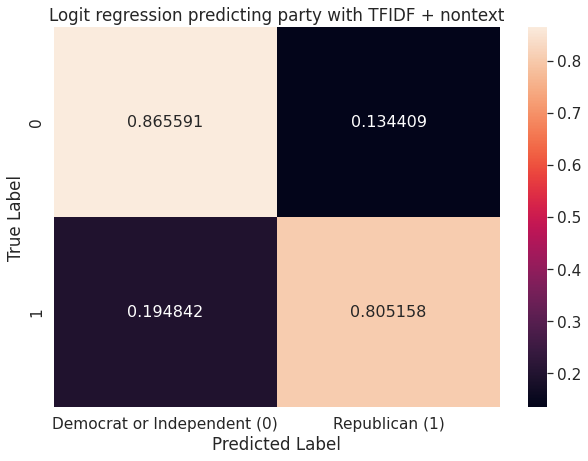

The logit regression's accuracy is: 0.8445
The logit regression's F1 score is: 0.7832752613240418


In [37]:
# split training and test set
X_train, X_test, y_party_train, y_party_test = train_test_split(non_text_plus_tfidf, Y_party["party_recoded_Republican"],
                                                   train_size = .80,
                                                   test_size = .20,
                                                    random_state = 1)

# create a model using tfidf_nontext --> party
logit_reg = LogisticRegression()

logit_model = logit_reg.fit(X_train, y_party_train.ravel())
y_party_pred = logit_model.predict(X_test)
cf_matrix = confusion_matrix(y_party_test, y_party_pred, normalize = "true")
df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))
df_cm = df_cm.rename(index=str, columns={0: "Democrat or Independent (0)", 1: "Republican (1)"})
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
            annot=True,
            annot_kws={"size": 16},
            fmt='g')

plt.title("Logit regression predicting party with TFIDF + nontext")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# calculate accuracy score
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_party_test, y_party_pred)
print(f"The logit regression's accuracy is: {accuracy}")

# calculate F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_party_test, y_party_pred)
print("The logit regression's F1 score is:", f1)



David - Model 2
Using nontext feature & tf-idf to predict whether the tweet comes from Senator or Representative

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:806: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  opt_res = optimize.minimize(


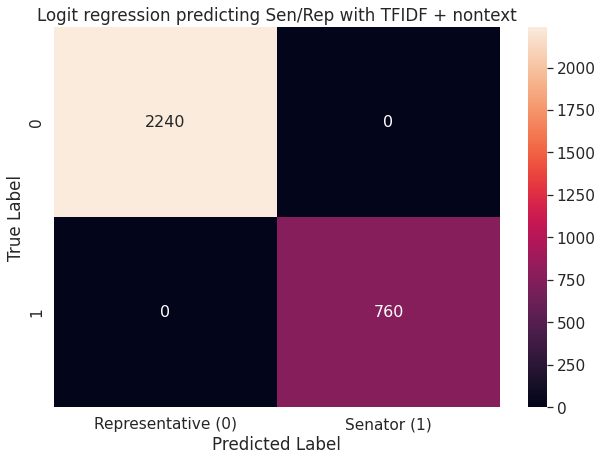

The logit regression's accuracy is: 1.0
The logit regression's F1 score is: 1.0


In [38]:
# split training and test set
X_train, X_test, y_train, y_test = train_test_split(non_text_plus_tfidf, Y_position["position_Sen"],
                                                   train_size = .70,
                                                   test_size = .30,
                                                    random_state = 2)

# create a model using tfidf_nontext --> senator/representative
logit_reg = LogisticRegression()

logit_model = logit_reg.fit(X_train, y_train.ravel())
y_pred = logit_model.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))
df_cm = df_cm.rename(index=str, columns={0: "Representative (0)", 1: "Senator (1)"})
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
            annot=True,
            annot_kws={"size": 16},
            fmt='g')

plt.title("Logit regression predicting Sen/Rep with TFIDF + nontext")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# calculate accuracy score
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"The logit regression's accuracy is: {accuracy}")

# calculate F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print("The logit regression's F1 score is:", f1)

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

Standard preprocessing techniques have to be customized to a particular corpus based on the unique characteristics of the corpus as well as to the research aims. For example, certain emojis in an internet based corpus may or may not be relevant to a specific research question.

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

The analyses suggest that the differences in sentiments between Democrats and Republicans are extremely minor, since the models all performed poorly without the inclusion of non-text features. There was slightly more differentiation between the sentiment of texts of Senators and Representatives.

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

Validating exploratory and unsupervised learning approaches with a supervised learning algorithm is valuable because it can provide feedback and comparison of the accuracy of different unsupervised methods. Alternatively, for the prediction of party membership, the prediction accuracy on a classification task shed light on the degree of polerization in the congress.

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

The combination of text and non-text features performed best. The intuition of combining text and non-text features together is that more information makese better predictions. In analyses for inference, the downside of more features is the risk of overfitting. However, in this situation, we are not concerned with generalizing the model to any outside corpus, and so the input of both text and non-text features only improves predictive power. We also have a suggestion that if we shift the data structure to combine all the tweets from the same senator/representative in to 1 observation, the prediction task may perform better.